# feedforward artificial neural network

see description & style notes at https://github.com/sparshsah/foggy-ml/blob/main/README.md, as well as https://github.com/sparshsah/foggy-demo/blob/main/demo/README.md

In [1]:
# set path: add top-level local repo dir to PYTHONPATH
# enables e.g. `import foggy_ml.fann`
"""
could also accomplish by:
for Mac: `sh$ export PYTHONPATH="$PYTHONPATH:/path/to/foggy-ml"`
for Windows: edit your environment variables
"""
import os, sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))  # ../.. = fann/ -> _demo/ -> foggy-ml/ = /path/to/foggy-ml
del sys, os

# https://github.com/sparshsah/foggy-ml/blob/main/_demo/fann/util.py
from util import *

# unit tests

TODO(sparshsah): i couldn't get `runpy.run_path(name='__main__')` to work here. i used my second choice, the `%run` cell magic which is at least preferable to the `!python` shell command.

In [2]:
"""
the "RuntimeWarning: divide by zero encountered in log" is annoying but expected, result is -\infty.
tried to silence by "with np.errstate(divide='ignore')" in unit test sourcefile,
but that doesn't seem to silence pd's identical warning.
"""
%run "../../_test/test_util.py"

....................................................................../Users/sparshsah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
.............
----------------------------------------------------------------------
Ran 83 tests in 0.590s

OK


In [3]:
%run "../../_test/fann/test_fann.py"

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


# inspect datasets

In [4]:
# preview
d = "train"
pd.concat([data[d]["X"], data[d]["y"]], axis="columns", keys=["X", "y"])

X            y
            0         1  0
0   -1.720010 -0.592602  0
1   -0.263360  1.315617  0
2   -0.811233  0.593363  0
3    0.108340  1.623423  0
4   -0.252440 -0.046977  1
..        ...       ... ..
251  0.370235 -1.117875  1
252  1.783155 -0.707722  1
253 -1.453746  0.273004  0
254  1.045813 -0.978903  1
255 -0.767574 -0.051766  1

[256 rows x 3 columns]

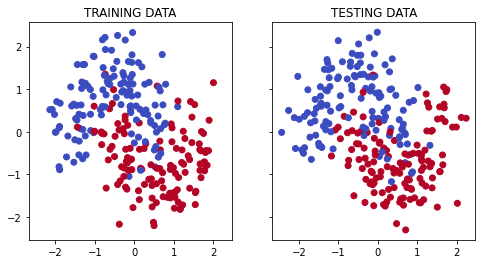

In [5]:
d0, d1 = "train", "test"
plot_datas(X0=data[d0]["X"], y0=data[d0]["y"], title0=titlefy(d=d0),
           X1=data[d1]["X"], y1=data[d1]["y"], title1=titlefy(d=d1))
del d1, d0, d

# "cheat" off a reference model

In [6]:
d = "train"
ref_model = RefNN(hidden_layer_sizes=LAYER_WIDTH, activation="logistic",
                  solver="lbfgs", max_iter=2048, random_state=1337).fit(X=data[d]["X"], y=data[d]["y"])
del d

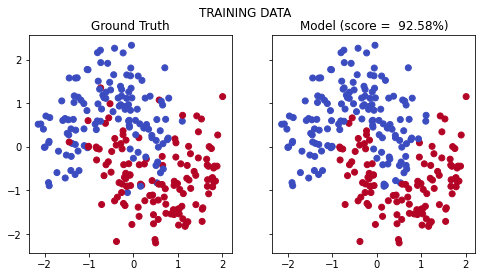

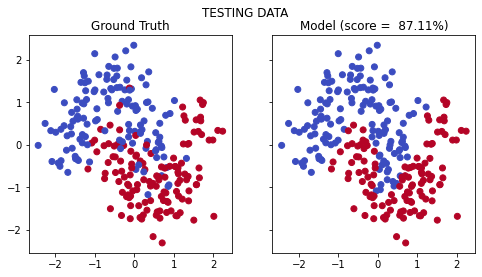

In [7]:
plot_perfs(pred_fn=ref_model.predict)

## replicate

In [8]:
model = homebrewify(ref_nn=ref_model)
model

_bias_          0          1          2          3
0 0   1.725117   7.327187  -2.921924        NaN        NaN
  1  24.893589  -9.762875  18.115036        NaN        NaN
  2 -36.967182  38.068971 -15.083768        NaN        NaN
  3   2.047638   9.795056  -2.187229        NaN        NaN
1 0 -12.026772 -42.270818  11.719440 -14.449423  46.745650
  1  13.692673  35.706143 -12.362756  23.186427 -29.639063
  2  17.771317  22.883641 -23.980883  31.556771   5.942327
2 0   5.658799  60.472675 -35.595721 -29.035015        NaN
  1  -5.658799 -60.472675  35.595721  29.035015        NaN

In [9]:
"""
check that our final layer's (pre-squash) outgoing activation is already a well-formed PMF,
thereby "proving" that `homebrewify()` (see comments therein) did the arithmetic correctly in transforming sklearn's
single-output-neuron format for binary classification to our 2-output-neuron format
"""
for d in "train", "test":
    # take the features dataframe
    data[d]["X"].apply(
        # forward-propagate (but don't squash) each observation i.e. row
        lambda x: fann.___fprop(x=x, nn=model), axis="columns").apply(
        # check that each result is a well-formed PMF
        util.check_pmf, axis="columns")
del d

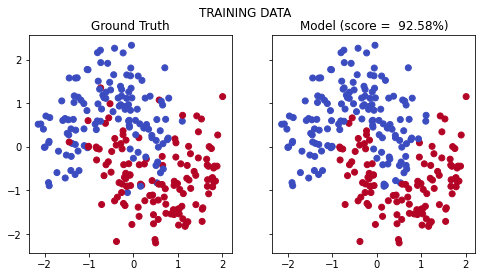

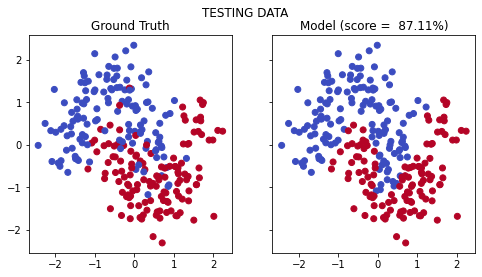

In [10]:
plot_perfs(pred_fn=lambda X: fann.predict(X=X, nn=model))

# illustration of what's going on "under the hood" in fprop

In [12]:
# model's predicted probabilities of each category label
fann._fprop(x=pd.Series([-1, 2]), nn=model)

0    0.713305
1    0.286695
dtype: float64

In [13]:
# look, activations[2, outgoing] matches those probabilities!
fann._fprop(x=pd.Series([-1, 2]), nn=model, expand=True)

a_in         a_out
0 0 -13.171036  1.069291e-05
  1  45.992948  1.000000e+00
  2 -68.236506  2.044649e-46
  3 -14.169514  5.439188e-06
1 0  11.719242  4.237178e-01
  1 -12.362535  7.908634e-01
  2 -23.980606  2.006633e-03
2 0  -2.586268  7.133051e-01
  1   2.586268  2.866949e-01

In [14]:
# same as above, but now output's outgoing activation is not squashed yet
a = fann.__fprop(x=pd.Series([-1, 2]), nn=model, expand=True)
a

a_in         a_out
0 0 -13.171036  1.069291e-05
  1  45.992948  1.000000e+00
  2 -68.236506  2.044649e-46
  3 -14.169514  5.439188e-06
1 0  11.719242  4.237178e-01
  1 -12.362535  7.908634e-01
  2 -23.980606  2.006633e-03
2 0  -2.586268  9.557453e-01
  1   2.586268  4.425466e-02

In [15]:
# how could we replicate the calculation for the post-squash probabilities of Category 0/1?
util.softmax(a.loc[2, "a_out"])

0    0.713305
1    0.286695
Name: a_out, dtype: float64

In [16]:
# how could we _more explicitly_ replicate the calculation for the post-squash probability of Category 0?
np.exp(a.loc[(2, 0), "a_out"])/(np.exp(a.loc[(2, 0), "a_out"])+np.exp(a.loc[(2, 1), "a_out"]))

0.7133051059892002

In [11]:
# just as a reminder
model

_bias_          0          1          2          3
0 0   1.725117   7.327187  -2.921924        NaN        NaN
  1  24.893589  -9.762875  18.115036        NaN        NaN
  2 -36.967182  38.068971 -15.083768        NaN        NaN
  3   2.047638   9.795056  -2.187229        NaN        NaN
1 0 -12.026772 -42.270818  11.719440 -14.449423  46.745650
  1  13.692673  35.706143 -12.362756  23.186427 -29.639063
  2  17.771317  22.883641 -23.980883  31.556771   5.942327
2 0   5.658799  60.472675 -35.595721 -29.035015        NaN
  1  -5.658799 -60.472675  35.595721  29.035015        NaN

# train our own homebrew model from scratch

In [17]:
fann.init_nn(input_width=NUM_FEATURES, layer_width=LAYER_WIDTH, output_width=NUM_CATEGORIES)

_bias_         0         1         2         3
0 0  0.038268  0.335124 -0.097401       NaN       NaN
  1 -1.389334  1.781993 -0.711626       NaN       NaN
  2  1.856816 -1.769448  0.104889       NaN       NaN
  3 -0.086123  1.500211  0.364173       NaN       NaN
1 0 -0.532864  0.618905  0.102681  0.906488 -0.108668
  1  0.093923 -0.066898 -0.567332  0.423892  0.338556
  2  0.872689 -0.168334  0.508933  0.553086 -0.019302
2 0 -0.817302 -0.091328 -0.865462 -0.846608       NaN
  1  0.732011 -0.993259 -1.071343  0.249740       NaN

In [18]:
d = "train"
fann.train(y=data[d]["y"], X=data[d]["X"], layer_width=LAYER_WIDTH)

ValueError: cannot join with no overlapping index names